<a href="https://colab.research.google.com/github/danishhdean/ARM/blob/main/ARM_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Apriori Algorithm

In [ ]:
!pip install mlxtend pyfpgrowth pandas matplotlib seaborn networkx


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyfpgrowth: filename=pyfpgrowth-1.0-py2.py3-none-any.whl size=5490 sha256=2ec14f5d700c5f9b72a4a5115009396ae1d1a585ae28afe6b2ab61e1e73b7d6b
  Stored in directory: /root/.cache/pip/wheels/f2/cf/03/d025f5c38b5e9cfbbe5e68ec539c2bf8dee7a9f8ee14629e2d
Successfully built pyfpgrowth


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
!pip install apyori
from apyori import apriori as apyori_apriori


#Importing the dataset
store_data = pd.read_excel('Lab 1-ARM-Dataset.xlsx', header=None)
store_data.head()

# Step 1: Extract item names from the first row (manual header), excluding the first column (Transaction ID)
header = store_data.iloc[0, 1:].tolist()  # Extract item names from the second column onward

# Step 2: Keep the Transaction ID column (first column)
store_data_clean = store_data.iloc[1:, :]  # Keep all columns including the Transaction ID column

# Step 3: Replace 1 with item name, keep 0 as is (no changes to the first column, which is Transaction ID)
store_data_named = store_data_clean.apply(
    lambda row: [row[0]] + [header[i-1] if val == 1 else 0 for i, val in enumerate(row[1:], start=1)], axis=1
)

# Step 4: Convert to DataFrame and assign correct headers (Transaction ID as the first column)
store_data_named_df = pd.DataFrame(store_data_named.tolist(), columns=['Transaction ID'] + header)

# Step 5: Display the result
store_data_named_df.head()

  Preparing metadata (setup.py) ... done
  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5954 sha256=1419b379c3f0ea95cb5c5de5b5d8c2b20e7e2b8656ff438005ddcfea18c61703
  Stored in directory: /root/.cache/pip/wheels/77/3d/a6/d317a6fb32be58a602b1e8c6b5d6f31f79322da554cad2a5ea
Successfully built apyori


,Transaction ID,Bread,Milk,Diaper,Beer,Cola,Chicken,Eggs,Apple,Juice,Banana
0,1,Bread,Milk,0,Beer,0,0,Eggs,0,0,Banana
1,2,Bread,0,Diaper,Beer,Cola,0,Eggs,Apple,0,0
2,3,Bread,Milk,Diaper,0,Cola,Chicken,0,Apple,Juice,0
3,4,0,Milk,Diaper,Beer,0,Chicken,Eggs,0,Juice,0
4,5,Bread,Milk,Diaper,0,Cola,0,0,Apple,0,Banana


One-hot Encoded Dataset:
    Apple  Banana   Beer  Bread  Chicken   Cola  Diaper   Eggs  Juice   Milk
0  False    True   True   True    False  False   False   True  False   True
1   True   False   True   True    False   True    True   True  False  False
2   True   False  False   True     True   True    True  False   True   True
3  False   False   True  False     True  False    True   True   True   True
4   True    True  False   True    False   True    True  False  False   True

Frequent Itemsets (min_support=0.3):
      support                 itemsets
0   0.600000                  (Apple)
1   0.333333                 (Banana)
2   0.466667                   (Beer)
3   0.733333                  (Bread)
4   0.600000                (Chicken)
5   0.600000                   (Cola)
6   0.733333                 (Diaper)
7   0.600000                   (Eggs)
8   0.533333                  (Juice)
9   0.666667                   (Milk)
10  0.400000           (Bread, Apple)
11  0.333333         (A

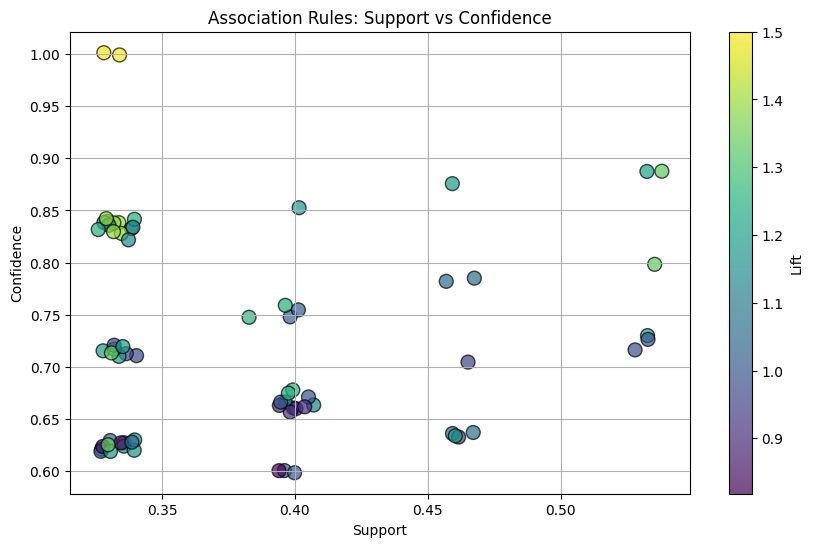

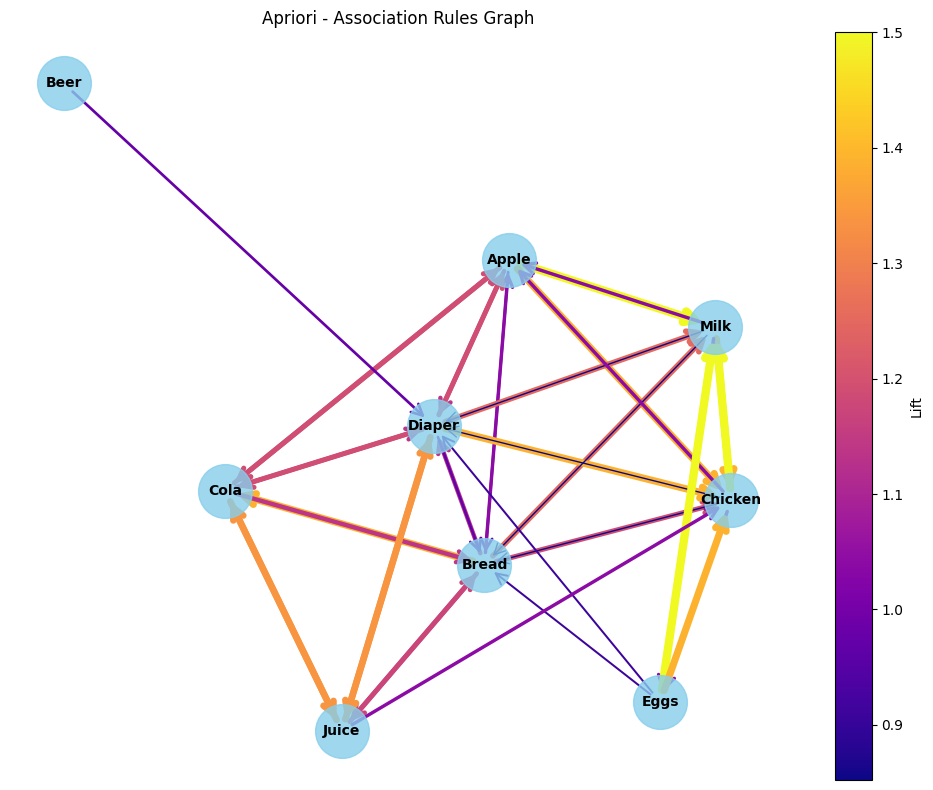

In [ ]:
transactions = []
for index, row in store_data_named_df.iterrows():
    transaction = [item for item in row[1:] if item != 0]  # skip Transaction ID and empty items
    transactions.append(transaction)

# Convert transactions into one-hot encoded DataFrame using TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

print("One-hot Encoded Dataset:\n", df.head())

# Mine frequent itemsets with min_support=0.3
frequent_itemsets = apriori(df, min_support=0.3, use_colnames=True)
print("\nFrequent Itemsets (min_support=0.3):\n", frequent_itemsets)

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
print("\nAssociation Rules (min_confidence=0.6):\n", rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

if not rules.empty:
    for idx, row in rules.iterrows():
        if len(row['antecedents']) > 0 and len(row['consequents']) > 0:
            print(f"Example Rule: {list(row['antecedents'])} → {list(row['consequents'])}")
            print(f"Support: {row['support']:.2f} (Occurs in {row['support'] * 100:.0f}% of transactions)")
            print(f"Confidence: {row['confidence']:.2f} (If {list(row['antecedents'])}, then {list(row['consequents'])} occurs {row['confidence'] * 100:.0f}% of the time)")
            print(f"Lift: {row['lift']:.2f} (This rule is {row['lift']:.1f}x more likely than random chance)")
            break  # Stop after the first valid rule
else:
    print("No valid rules generated.")

# ---------- 3.1: Scatter Plot (with Jitter) ----------
x_jitter = rules['support'] + np.random.normal(0, 0.005, len(rules))
y_jitter = rules['confidence'] + np.random.normal(0, 0.005, len(rules))

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    x_jitter,
    y_jitter,
    c=rules['lift'],
    cmap='viridis',
    s=100,
    alpha=0.7,
    edgecolors='k'
)
plt.colorbar(scatter, label='Lift')
plt.title('Association Rules: Support vs Confidence')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.grid(True)
plt.show()

# ---------- Network Graph Visualization ----------
def plot_rules_network(rules, title="Association Rules Graph"):
    if rules.empty:
        print(f"No rules to plot for {title}")
        return

    G = nx.DiGraph()

    for _, row in rules.iterrows():
        for antecedent in row['antecedents']:
            for consequent in row['consequents']:
                G.add_edge(
                    antecedent, consequent,
                    weight=row['lift'],
                    support=row['support'],
                    confidence=row['confidence']
                )

    pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)
    plt.figure(figsize=(10, 8))
    edges = G.edges(data=True)

    edge_weights = [data['weight'] for _, _, data in edges]
    norm = plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
    edge_colors = plt.cm.plasma(norm(edge_weights))

    for (edge, color, width) in zip(edges, edge_colors, norm(edge_weights) * 5 + 1):
        nx.draw_networkx_edges(
            G, pos,
            edgelist=[(edge[0], edge[1])],
            arrowstyle='->', arrowsize=20,
            edge_color=[color],
            width=width
        )

    nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='skyblue', alpha=0.8)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

    sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label('Lift')

    plt.title(f'{title} - Association Rules Graph')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot network if rules exist
plot_rules_network(rules, title="Apriori")


## FP-growth Algorithm

Frequent Itemsets (FP-Growth):
      support                 itemsets
0   0.733333                  (Bread)
1   0.666667                   (Milk)
2   0.600000                   (Eggs)
3   0.466667                   (Beer)
4   0.333333                 (Banana)
5   0.733333                 (Diaper)
6   0.600000                   (Cola)
7   0.600000                  (Apple)
8   0.600000                (Chicken)
9   0.533333                  (Juice)
10  0.466667            (Bread, Milk)
11  0.400000           (Diaper, Milk)
12  0.400000             (Milk, Eggs)
13  0.400000            (Bread, Eggs)
14  0.400000           (Diaper, Eggs)
15  0.333333          (Chicken, Eggs)
16  0.333333    (Chicken, Milk, Eggs)
17  0.333333           (Diaper, Beer)
18  0.533333          (Bread, Diaper)
19  0.533333            (Bread, Cola)
20  0.466667           (Cola, Diaper)
21  0.400000    (Bread, Cola, Diaper)
22  0.466667          (Diaper, Apple)
23  0.400000            (Cola, Apple)
24  0.400000      

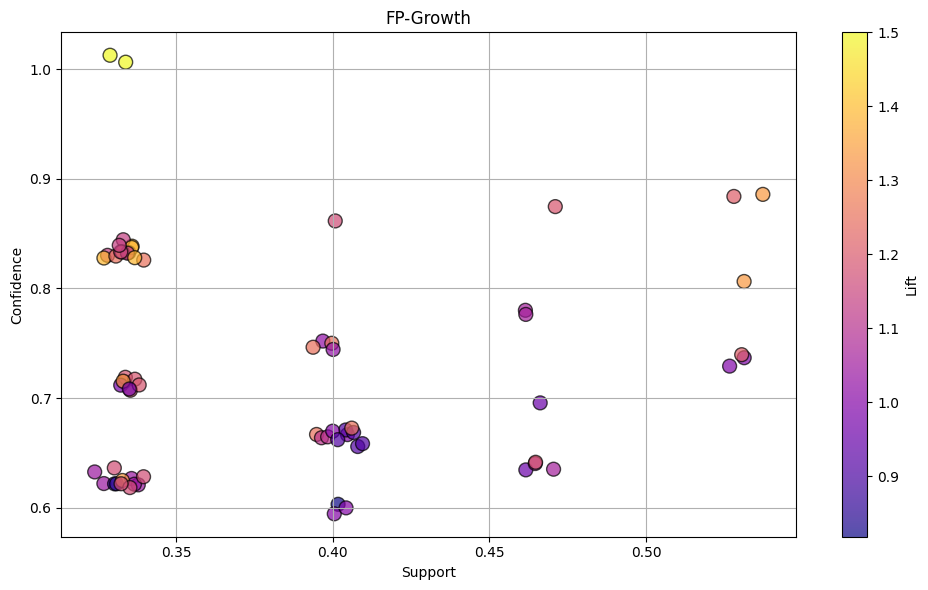

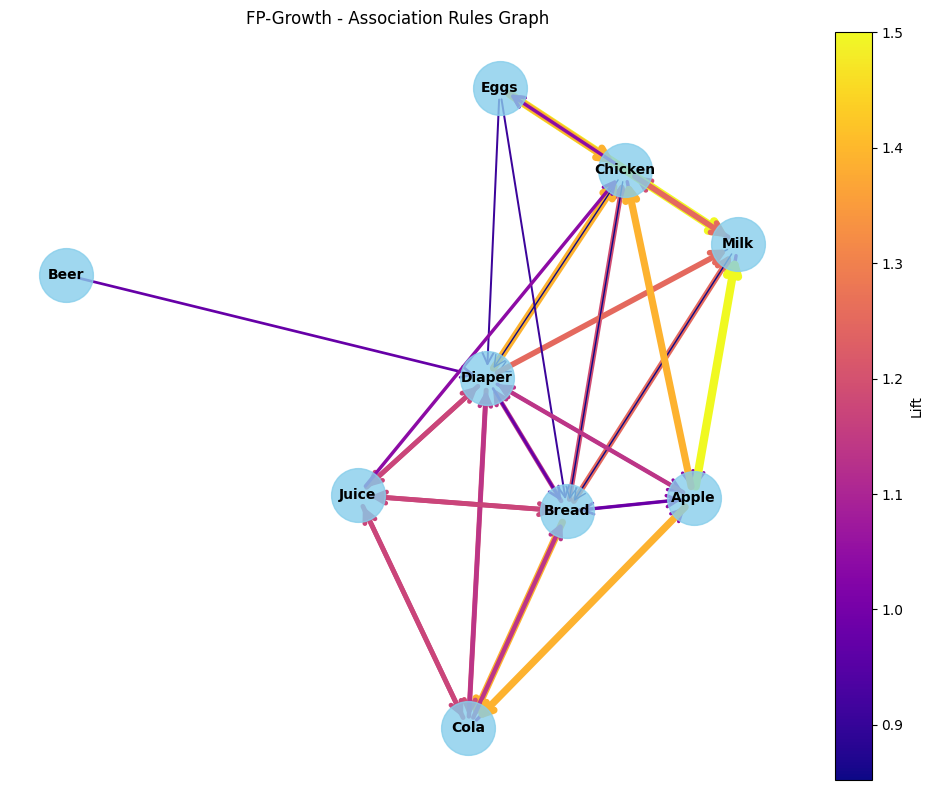

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules

# Load dataset
store_data = pd.read_excel('Lab 1-ARM-Dataset.xlsx', header=None)

# Step 1: Extract item names from the first row (manual header), excluding the first column (Transaction ID)
header = store_data.iloc[0, 1:].tolist()

# Step 2: Keep the Transaction ID column
store_data_clean = store_data.iloc[1:, :]

# Step 3: Replace 1s with item names
store_data_named = store_data_clean.apply(
    lambda row: [row[0]] + [header[i-1] if val == 1 else 0 for i, val in enumerate(row[1:], start=1)], axis=1
)

# Step 4: Convert to DataFrame and assign headers
store_data_named_df = pd.DataFrame(store_data_named.tolist(), columns=['Transaction ID'] + header)

# Step 5: Prepare transactions
transactions = []
for i in range(store_data_named_df.shape[0]):
    transaction = store_data_named_df.iloc[i, 1:].tolist()
    transaction = [item for item in transaction if item != 0]
    transactions.append(transaction)

# One-hot encode the transactions
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# Apply FP-Growth
frequent_itemsets_fp = fpgrowth(df, min_support=0.3, use_colnames=True)
print("Frequent Itemsets (FP-Growth):\n", frequent_itemsets_fp)

# Generate rules
rules_fp = association_rules(frequent_itemsets_fp, metric="confidence", min_threshold=0.6)
print("\nFP-Growth Association Rules:\n", rules_fp[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

# ---------- Scatter Plot Visualization (with jitter) ----------
def plot_rules_scatter(rules, title="Association Rules: Support vs Confidence"):
    if rules.empty:
        print(f"No rules to plot for {title}")
        return

    x = rules['support'].values
    y = rules['confidence'].values
    c = rules['lift'].values

    # Apply jitter
    jitter_strength = 0.005
    x_jittered = x + np.random.normal(0, jitter_strength, size=len(x))
    y_jittered = y + np.random.normal(0, jitter_strength, size=len(y))

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        x_jittered, y_jittered,
        c=c,
        cmap='plasma',
        s=100,
        alpha=0.7,
        edgecolors='k'
    )

    plt.colorbar(scatter, label='Lift')
    plt.title(title)
    plt.xlabel('Support')
    plt.ylabel('Confidence')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



# ---------- Network Graph Visualization ----------
def plot_rules_network(rules, title="Association Rules Graph"):
    if rules.empty:
        print(f"No rules to plot for {title}")
        return

    G = nx.DiGraph()

    for _, row in rules.iterrows():
        for antecedent in row['antecedents']:
            for consequent in row['consequents']:
                G.add_edge(
                    antecedent, consequent,
                    weight=row['lift'],
                    support=row['support'],
                    confidence=row['confidence']
                )

    pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)
    plt.figure(figsize=(10, 8))
    edges = G.edges(data=True)

    edge_weights = [data['weight'] for _, _, data in edges]
    norm = plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
    edge_colors = plt.cm.plasma(norm(edge_weights))

    for (edge, color, width) in zip(edges, edge_colors, norm(edge_weights) * 5 + 1):
        nx.draw_networkx_edges(
            G, pos,
            edgelist=[(edge[0], edge[1])],
            arrowstyle='->', arrowsize=20,
            edge_color=[color],
            width=width
        )

    nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='skyblue', alpha=0.8)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

    sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label('Lift')

    plt.title(f'{title} - Association Rules Graph')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# ---------- Plot Both ----------
plot_rules_scatter(rules_fp, title="FP-Growth")
plot_rules_network(rules_fp, title="FP-Growth")


In [ ]:
import time
from mlxtend.frequent_patterns import apriori as mlxtend_apriori, fpgrowth, association_rules

# ---------- Measure Apriori (Frequent Itemsets + Rules) ----------
start_apriori = time.time()

# Frequent itemsets using Apriori
frequent_itemsets_apriori = mlxtend_apriori(df, min_support=0.3, use_colnames=True)

# Association rules from Apriori itemsets
rules_apriori = association_rules(frequent_itemsets_apriori, metric="confidence", min_threshold=0.6)

end_apriori = time.time()
apriori_time = end_apriori - start_apriori

# ---------- Measure FP-growth (Frequent Itemsets + Rules) ----------
start_fpgrowth = time.time()

# Frequent itemsets using FP-growth
frequent_itemsets_fpgrowth = fpgrowth(df, min_support=0.3, use_colnames=True)

# Association rules from FP-growth itemsets
rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, metric="confidence", min_threshold=0.6)

end_fpgrowth = time.time()
fpgrowth_time = end_fpgrowth - start_fpgrowth

print(f"Apriori - Frequent Itemsets: {len(frequent_itemsets_apriori)}")
print(f"FP-growth - Frequent Itemsets: {len(frequent_itemsets_fpgrowth)}\n")

print(f"Apriori - Association Rules: {len(rules_apriori)}")
print(f"FP-growth - Association Rules: {len(rules_fpgrowth)}\n")

print(f"Apriori - Computation Time: {apriori_time:.4f} seconds")
print(f"FP-growth - Computation Time: {fpgrowth_time:.4f} seconds\n")

if apriori_time > fpgrowth_time:
    print("💡 FP-growth is faster for this dataset.")
else:
    print("💡 Apriori is faster for this dataset.")


Apriori - Frequent Itemsets: 43
FP-growth - Frequent Itemsets: 43

Apriori - Association Rules: 68
FP-growth - Association Rules: 68

Apriori - Computation Time: 0.0259 seconds
FP-growth - Computation Time: 0.0179 seconds

💡 FP-growth is faster for this dataset.


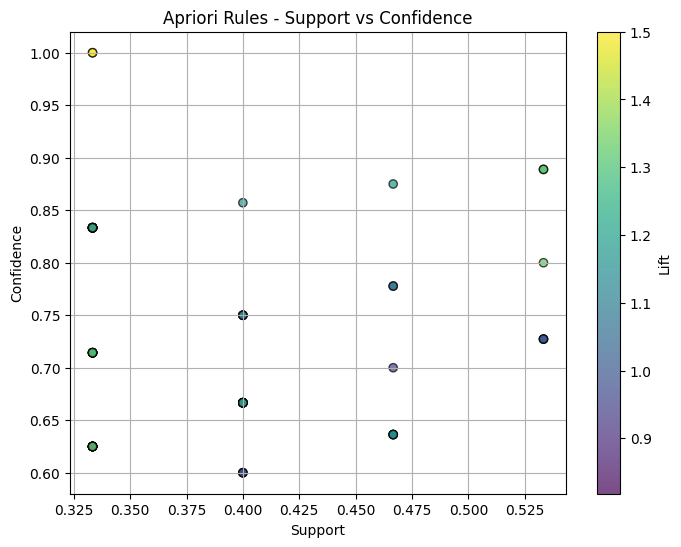


Interpretation for Apriori Rules Scatter Plot:
- Each point represents an association rule.
- X-axis (Support): Frequency of the rule in the dataset.
- Y-axis (Confidence): Reliability of the rule's prediction.
- Color scale (Lift): Strength of association (Lift > 1 suggests a strong rule).
- Points in the upper right with bright colors indicate valuable and reliable rules.



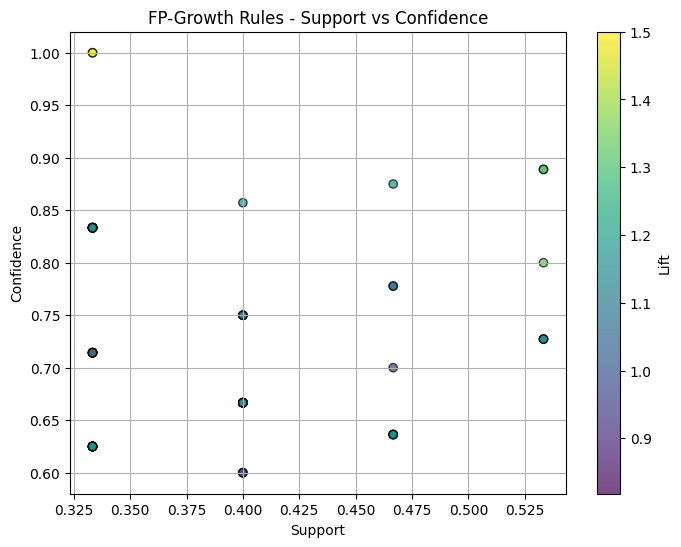


Interpretation for FP-Growth Rules Scatter Plot:
- Each point represents an association rule.
- X-axis (Support): Frequency of the rule in the dataset.
- Y-axis (Confidence): Reliability of the rule's prediction.
- Color scale (Lift): Strength of association (Lift > 1 suggests a strong rule).
- Points in the upper right with bright colors indicate valuable and reliable rules.



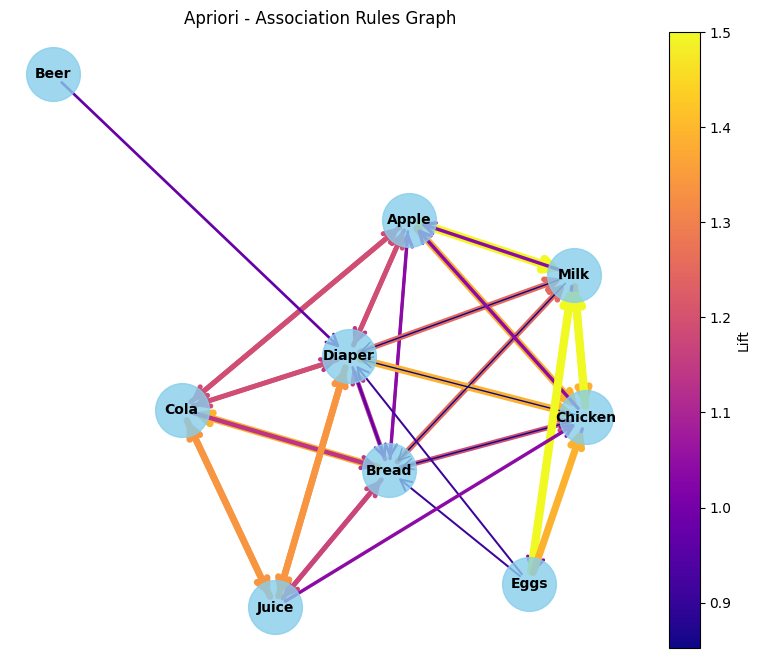


Interpretation for Apriori Network Graph:
- Nodes represent items involved in the rules.
- Arrows show the direction from antecedents to consequents.
- Edge thickness and color intensity reflect the Lift value (stronger = thicker/brighter).
- Central or highly connected nodes suggest items that play a key role in multiple rules.
- Groups of tightly connected nodes may indicate frequent itemsets or product bundles.



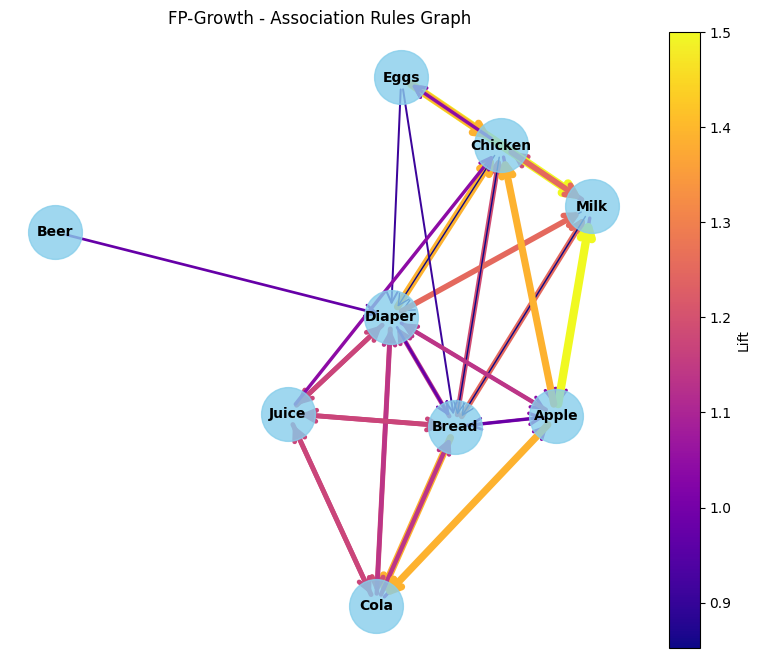


Interpretation for FP-Growth Network Graph:
- Nodes represent items involved in the rules.
- Arrows show the direction from antecedents to consequents.
- Edge thickness and color intensity reflect the Lift value (stronger = thicker/brighter).
- Central or highly connected nodes suggest items that play a key role in multiple rules.
- Groups of tightly connected nodes may indicate frequent itemsets or product bundles.



In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# ---------- 3.1: Scatter Plot Visualization ----------

def plot_scatter(rules, title):
    if rules.empty:
        print(f"No rules to plot for {title}")
        return
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(rules['support'], rules['confidence'],
                          c=rules['lift'], cmap='viridis', alpha=0.7, edgecolor='k')
    plt.colorbar(scatter, label='Lift')
    plt.title(f'{title} - Support vs Confidence')
    plt.xlabel('Support')
    plt.ylabel('Confidence')
    plt.grid(True)
    plt.show()

    # Interpretation
    print(f"\nInterpretation for {title} Scatter Plot:")
    print("- Each point represents an association rule.")
    print("- X-axis (Support): Frequency of the rule in the dataset.")
    print("- Y-axis (Confidence): Reliability of the rule's prediction.")
    print("- Color scale (Lift): Strength of association (Lift > 1 suggests a strong rule).")
    print("- Points in the upper right with bright colors indicate valuable and reliable rules.\n")

plot_scatter(rules_apriori, 'Apriori Rules')
plot_scatter(rules_fpgrowth, 'FP-Growth Rules')

# ---------- 3.2: Network Graph Visualization ----------

def plot_rules_network(rules, title):
    if rules.empty:
        print(f"No rules to plot for {title}")
        return

    G = nx.DiGraph()

    for _, row in rules.iterrows():
        for antecedent in row['antecedents']:
            for consequent in row['consequents']:
                G.add_edge(antecedent, consequent, weight=row['lift'],
                           support=row['support'], confidence=row['confidence'])

    pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)
    plt.figure(figsize=(10, 8))
    edges = G.edges(data=True)

    edge_weights = [data['weight'] for _, _, data in edges]

    # Normalize lift for color mapping
    norm = plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
    edge_colors = plt.cm.plasma(norm(edge_weights))

    for (edge, color, width) in zip(edges, edge_colors, norm(edge_weights)*5 + 1):
        nx.draw_networkx_edges(
            G, pos,
            edgelist=[(edge[0], edge[1])],
            arrowstyle='->', arrowsize=20,
            edge_color=[color],
            width=width
        )

    nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='skyblue', alpha=0.8)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

    sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label('Lift')

    plt.title(f'{title} - Association Rules Graph')
    plt.axis('off')
    plt.show()

    # Interpretation
    print(f"\nInterpretation for {title} Network Graph:")
    print("- Nodes represent items involved in the rules.")
    print("- Arrows show the direction from antecedents to consequents.")
    print("- Edge thickness and color intensity reflect the Lift value (stronger = thicker/brighter).")
    print("- Central or highly connected nodes suggest items that play a key role in multiple rules.")
    print("- Groups of tightly connected nodes may indicate frequent itemsets or product bundles.\n")

plot_rules_network(rules_apriori, 'Apriori')
plot_rules_network(rules_fpgrowth, 'FP-Growth')